# Getting Started on Vertex AI Notebooks #

This notebook demonstrates how to do the following on Vertex AI, Google's powerful new machine learning platform:

- run the getting started notebook on Vertex AI Notebooks, to load the data, create a model & generate predictions
- explore explainable AI on Vertex AI to refine your features
- tune hyperparameters with Vizier

It is a complement to the [Getting Started with MLB Digital Engagement](https://www.kaggle.com/ryanholbrook/getting-started-with-mlb-player-digital-engagement) tutorial which was designed to be run on Kaggle Notebooks.

This tutorial uses Cloud Notebooks, a billable component of Google Cloud. Learn more about [Notebooks pricing](https://cloud.google.com/notebooks/pricing).

# Notebook Setup #


### 1. Download this Notebook ###

Start by creating your own copy of this notebook. Click the *Copy and Edit* button to the upper right. Now, in the menubar above, click *File -> Download Notebook* and save a copy of the notebook to your computer. We will reupload this in an AI Notebooks instance to take advantage of the Explainable AI service.

### 2. Download Kaggle API Key ###
We'll use the Kaggle API to download the competition data to the notebook instance. You'll need a copy of your Kaggle credentials to authenticate your account.

From the site header, click on your user profile picture, then on “My Account” from the dropdown menu. This will take you to your account settings at https://www.kaggle.com/account. Scroll down to the section of the page labelled API.

To create a new token, click on the “Create New API Token” button. This will download a fresh authentication token onto your machine.

### 3. Sign up for Google Cloud Platform ###
If you don't have a GCP account already, go to https://cloud.google.com/ and click on “Get Started For Free". This is a two step sign up process where you will need to provide your name, address and a credit card. The starter account is free and it comes with $300 credit that you can use. For this step you will need to provide a Google Account (i.e. your Gmail account) to sign in.

### 4. Create a Project and Enable the Notebook API ###
Follow the directions at https://cloud.google.com/notebooks/docs/before-you-begin to setup a notebook project.

### 5. Create a Notebook Instance ###
Next, go to https://notebook.new. Enter an `Instance name` of your choice and then click the blue **CREATE** button at the end of the page. Be sure to keep the default `TensorFlow Enterprise` environment. You'll be redirected to a page with a list of your notebook instances. It may take a few minutes for the instance you just created to start up.

Once the notebook instance is running, click `OPEN JUPYTERLAB` just to the right of the instance name. You should be redirected to a JupyterLab environment.

### 6. Upload MLB Notebook and API Key ###
From inside JupyterLab, click the "Upload Files" (up arrow) button in the file browser on the left and upload the files `kaggle.json` and `vertex-ai-with-mlb-player-digital-engagement.ipynb`.

### 7. Authenticate Kaggle API and Download MLB Date ###

Run the next cell to download the competition data.

In [1]:
%%bash

pip install -q kaggle
mkdir -p /home/jupyter/.kaggle
mv kaggle.json /home/jupyter/.kaggle/kaggle.json 2>/dev/null
chmod 600 /home/jupyter/.kaggle/kaggle.json

kaggle competitions download mlb-player-digital-engagement-forecasting
# JF allow non-home-dir runs
#mkdir -p /home/jupyter/input
#unzip -u mlb-player-digital-engagement-forecasting.zip -d /home/jupyter/input/mlb-player-digital-engagement-forecasting
mkdir -p ./input
unzip -u mlb-player-digital-engagement-forecasting.zip -d ./input/mlb-player-digital-engagement-forecasting

mlb-player-digital-engagement-forecasting.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  mlb-player-digital-engagement-forecasting.zip


### 9. Run this Tutorial ###

After you've completed the setup steps above in Vertex AI Notebooks, select "Run" from the menubar and "Run Selected Cell and All Below" to run through the rest of this notebook automatically. Or step through cell-by-cell, if you'd prefer. Note that the Explainable AI (XAI) walkthrough is at the bottom of this notebook.

### 8. Cleaning Up ###

You'll be billed for any time you keep the notebook instance running. So after you're done, be sure either to stop the notebook instance from the *Notebooks* page, or else to delete the Cloud project you created.

# MLB Getting Started #

The first part of this notebook reproduces the data and model setup of the [Getting Started](https://www.kaggle.com/ryanholbrook/getting-started-with-mlb-player-digital-engagement) notebook.

In [2]:
import gc
import sys
import warnings
from joblib import Parallel, delayed
from pathlib import Path

import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from statsmodels.tsa.deterministic import (CalendarFourier,
                                           CalendarSeasonality,
                                           CalendarTimeTrend,
                                           DeterministicProcess)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
# JF this triggers an exception and is not actually used
#from keras.layers.experimental.preprocessing import StringLookup

In [4]:
warnings.simplefilter("ignore")

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)

In [5]:
# Helper function to unpack json found in daily data
def unpack_json(json_str):
    return pd.DataFrame() if pd.isna(json_str) else pd.read_json(json_str)


def unpack_data(data, dfs=None, n_jobs=-1):
    if dfs is not None:
        data = data.loc[:, dfs]
    unnested_dfs = {}
    for name, column in data.iteritems():
        daily_dfs = Parallel(n_jobs=n_jobs)(
            delayed(unpack_json)(item) for date, item in column.iteritems())
        df = pd.concat(daily_dfs)
        unnested_dfs[name] = df
    return unnested_dfs

In [6]:
data_dir = Path('./input/mlb-player-digital-engagement-forecasting/')

df_names = ['seasons', 'teams', 'players', 'awards']

for name in df_names:
    globals()[name] = pd.read_csv(data_dir / f"{name}.csv")

kaggle_data_tabs = widgets.Tab()
# Add Output widgets for each pandas DF as tabs' children
kaggle_data_tabs.children = list([widgets.Output() for df_name in df_names])

for index in range(0, len(df_names)):
    # Rename tab bar titles to df names
    kaggle_data_tabs.set_title(index, df_names[index])
    
    # Display corresponding table output for this tab name
    with kaggle_data_tabs.children[index]:
        display(eval(df_names[index]))

display(kaggle_data_tabs)

In [7]:
# Define dataframes to load from training set
dfs = [
    'nextDayPlayerEngagement',  # targets
    'playerBoxScores',  # features
    # Other dataframes available for features:
    # 'games',
    # 'rosters',
    # 'teamBoxScores',
    # 'transactions',
    # 'standings',
    # 'awards',
    # 'events',
    # 'playerTwitterFollowers',
    # 'teamTwitterFollowers',
]

# Read training data
training = pd.read_csv(
    data_dir / 'train.csv',
    usecols=['date'] + dfs,
)

# Convert training data date field to datetime type
training['date'] = pd.to_datetime(training['date'], format="%Y%m%d")
training = training.set_index('date').to_period('D')
print(training.info())

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 1216 entries, 2018-01-01 to 2021-04-30
Freq: D
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   nextDayPlayerEngagement  1216 non-null   object
 1   playerBoxScores          538 non-null    object
dtypes: object(2)
memory usage: 28.5+ KB
None


In [8]:
# Unpack nested dataframes and store in dictionary `training_dfs`
training_dfs = unpack_data(training, dfs=dfs)
print('\n', training_dfs.keys())


 dict_keys(['nextDayPlayerEngagement', 'playerBoxScores'])


The results of Explainable AI will be easier to understand if we restrict our analysis to a single player. The next cell has a helper function to load data for only a single player, by default Aaron Judge of the NY Yankees, who had the highest overall engagement during the training period.

In [9]:
pids_test = players.playerId.loc[
    players.playerForTestSetAndFuturePreds.fillna(False)
].astype(str)

def make_playerBoxScores(dfs: dict, features):
    X = dfs['playerBoxScores']
    X = X[['gameDate', 'playerId'] + features]
    # Create date index
    X = X.rename(columns={'gameDate': 'date'})
    X['date'] = pd.PeriodIndex(X.date, freq='D')
    # Aggregate multiple games per day by summing
    X = X.groupby(['date', 'playerId'], as_index=False).sum()
    return X


def make_targets(training_dfs: dict):
    Y = training_dfs['nextDayPlayerEngagement'].copy()
    # Match target dates to feature dates and create date index
    Y = Y.rename(columns={'engagementMetricsDate': 'date'})
    Y['date'] = pd.to_datetime(Y['date'])
    Y = Y.set_index('date').to_period('D')
    Y.index = Y.index - 1
    return Y.reset_index()


def join_datasets(dfs):
    dfs = [x.pivot(index='date', columns='playerId') for x in dfs]
    df = pd.concat(dfs, axis=1).stack().reset_index('playerId')
    return df


def make_training_data(training_dfs: dict,
                       features,
                       targets,
                       fourier=4,
                       player=592450,  # Aaron Judge of the NY Yankees
                       test_size=30):
    # Process dataframes
    X = make_playerBoxScores(training_dfs, features)
    Y = make_targets(training_dfs)
    # Merge for processing
    df = join_datasets([X, Y])
    # Process
    df = df.astype({'playerId': str})
    df = df.astype({name: np.float32 for name in features})
    # Filter for chosen player
    df = df.loc[df.playerId == str(player), :].drop('playerId', axis=1)
    for name in features:
        df[name] = df[name].fillna(-1)
    # Restore features and targets
    X = df[features]
    Y = df[targets]
    # Create temporal features
    fourier_terms = CalendarFourier(freq='A', order=fourier)
    deterministic = DeterministicProcess(
        index=X.index,
        order=0,
        seasonal=False,
        additional_terms=[fourier_terms],
    )
    X = pd.concat([X, deterministic.in_sample()], axis=1)
    # Create train / validation splits
    X_train, X_valid, y_train, y_valid = train_test_split(
        X,
        Y,
        test_size=test_size,
        shuffle=False,
    )
    return X_train, X_valid, y_train, y_valid, deterministic

We've picked out a few features from the `playerBoxScores` dataframe, but there are lots more you could try (see the [data documentation](https://www.kaggle.com/c/mlb-player-digital-engagement-forecasting/data) for a complete description). Increase the number of Fourier components to model seasonality with in more detail. You could also look at explanations for other players -- the `players` dataframe can tell you the `playerId` for each player.

In [10]:
player = 592450  # Aaron Judge of the NY Yankees
features = [
    "runsScored",
    "hits",
    "rbi",
    "atBats",
    "hitByPitch",
    "saves",
    "homeRuns",
    "stolenBases",
    "strikeOuts",
    "groundIntoTriplePlay",
    "totalBases",
]
fourier = 4  # number of annual seasonal components

targets = ["target1", "target2", "target3", "target4"]
test_size = 30

X_train, X_valid, y_train, y_valid, deterministic = make_training_data(
    training_dfs, 
    features=features, 
    targets=targets,
    fourier=4,
    player=592450,
    test_size=test_size,
)

# Model #

Now we'll create a neural network with Keras and fit it to our training data.

In [11]:
INPUTS = X_train.shape[-1]
OUTPUTS = y_train.shape[-1]
early_stopping = keras.callbacks.EarlyStopping(patience=10,
                                               restore_best_weights=True)

model = keras.Sequential([
    layers.InputLayer(name='numpy_inputs', input_shape=(INPUTS,)),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(OUTPUTS),
])


2022-03-14 16:56:05.520868: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [12]:
model.compile(
    optimizer='adam',
    loss='mae',
    metrics=['mae'],
)
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_valid, y_valid),
    epochs=50,
    callbacks=[early_stopping]
)

Epoch 1/50
38/38 [==============================] - 2s 15ms/step - loss: 18.3170 - mae: 18.3170 - val_loss: 16.4719 - val_mae: 16.4719
Epoch 2/50
38/38 [==============================] - 0s 6ms/step - loss: 17.9855 - mae: 17.9855 - val_loss: 16.0087 - val_mae: 16.0087
Epoch 3/50
38/38 [==============================] - 0s 7ms/step - loss: 17.5177 - mae: 17.5177 - val_loss: 14.9151 - val_mae: 14.9151
Epoch 4/50
38/38 [==============================] - 0s 8ms/step - loss: 16.7693 - mae: 16.7693 - val_loss: 13.3668 - val_mae: 13.3668
Epoch 5/50
38/38 [==============================] - 0s 9ms/step - loss: 15.7727 - mae: 15.7727 - val_loss: 11.8943 - val_mae: 11.8943
Epoch 6/50
38/38 [==============================] - 0s 9ms/step - loss: 14.6731 - mae: 14.6731 - val_loss: 10.7859 - val_mae: 10.7859
Epoch 7/50
38/38 [==============================] - 0s 7ms/step - loss: 13.7730 - mae: 13.7730 - val_loss: 10.9410 - val_mae: 10.9410
Epoch 8/50
38/38 [==============================] - 0s 10ms/s

# Evaluate #

We can get an idea of how well our network was able to fit the data by plotting its predictions.

In [13]:
y_fit = model.predict(X_train)
y_fit = pd.DataFrame(y_fit,
                     index=y_train.index,
                     columns=y_train.columns)
y_eval = model.predict(X_valid)
y_eval = pd.DataFrame(y_eval,
                      index=y_valid.index,
                      columns=y_valid.columns)

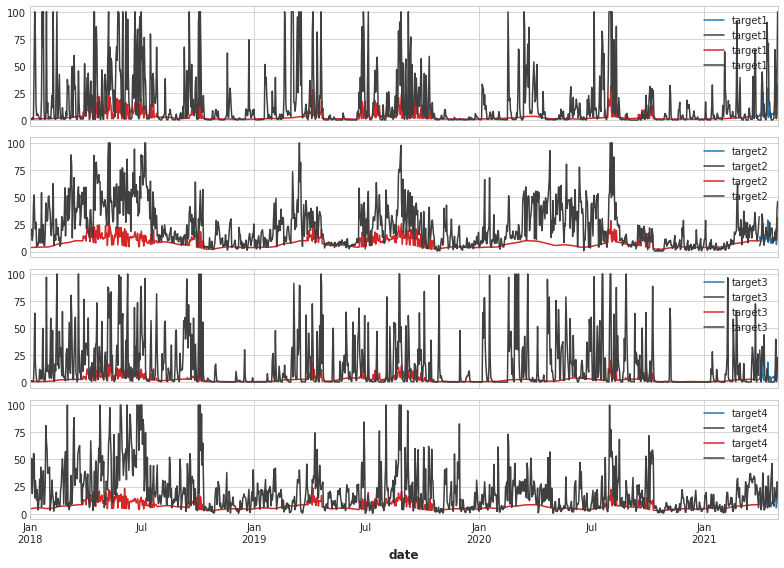

In [14]:
fig, ax = plt.subplots(figsize=(11, 8))
ax = y_eval.plot(ax=ax, subplots=True, color='C0')
ax = y_valid.plot(subplots=True,
                  sharex=True,
                  ax=ax,
                  color='0.25')
ax = y_fit.plot(subplots=True,
                sharex=True,
                ax=ax,
                color='C3')
ax = y_train.plot(subplots=True,
                  sharex=True,
                  ax=ax,
                  color='0.25')

# Explain #

Explainable AI on Vertex AI Notebooks lets you compute feature attributions for neural networks. Feature attributions describe the contribution each features makes to the final prediction relative to a baseline. Feature attributions can help you tune your model by indicating which features are important and which are not. Features with little importance you could consider dropping from your feature set.

Read more about Vertex Explainable AI here: [Introduction to Vertex Explainable AI for Vertex AI](https://cloud.google.com/vertex-ai/docs/explainable-ai/overview). In JupyterLab on Vertex AI Notebooks, you can also review a tutorial on XAI in the `tutorials` > `explainable_ai` > `sdk_tutorial.ipynb` file

Now we can look at explanations using the `explainable_ai_sdk` library. Run the following cell on AI Notebooks with a Cloud TF image to see model explanations.

In [15]:
!pip install --quiet explainable_ai_sdk

2022-03-14 16:56:23.330740: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: working/model/assets
Label Index 1
Example Score: 13.7280
Baseline Score: 5.5191
Approximation Error: 0.0019


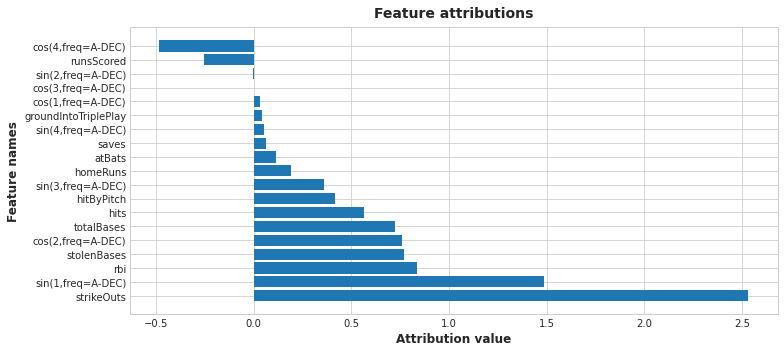

In [16]:
import os
import explainable_ai_sdk
from explainable_ai_sdk.model import configs
from explainable_ai_sdk.metadata.tf.v2 import SavedModelMetadataBuilder
if not   os.path.exists("working"):
  os.mkdir("working")
model_path = "working/model"
model.save(model_path)

builder = SavedModelMetadataBuilder(model_path)
builder.set_numeric_metadata(
    "numpy_inputs",
    input_baselines=[X_train.median().tolist()],  # attributions relative to the median of the target
    index_feature_mapping=X_train.columns.tolist(),  # the names of each feature
)
builder.save_metadata(model_path)

explainer = explainable_ai_sdk.load_model_from_local_path(
    model_path=model_path,
    config=configs.SampledShapleyConfig(path_count=20),
)

instances = list(X_valid.to_numpy())  # explanations for the validation set
explanations = explainer.explain(instances={'numpy_inputs': instances})[0]  # needs to match name of `InputLayer` in the model

explanations.visualize_attributions()

You should see a Feature Attributions chart above. Each of the attributions is computed on a given set of instances relative to a baseline, in our case the median on the training set. We've computed attributions for the validation set, the last 30 days of the data, but you could try a different set if you like by changing the `instances` parameter. To get attributions relative to another baseline (the mean, say), just change the computation for `input_baselines` above.

Our feature attribution chart suggest that features like `atBats` and `strikeOuts` are important for digital engagement with Aaron Judge, but `stolenBases` much less so. We also see that the model did make use of several of the Fourier features modeling annual seasonality.

# Hyperparameter Tuning with Vizier #

In the second half of this notebook, we'll demonstrate **Vertex Vizier**, Vertex AI's hyperparameter optimization service. Among its capabilities are a *Bayesian Optimization* algorithm to search efficiently within a hyperparameter space, *transfer learning* to make use of information from previous hyperparameter studies, and *automated early stopping* when tuning models that train incrementally, like neural nets with stochastic gradient descent or gradient boosted trees. Google Research has a great whitepaper describing the capabilities of Vizier in detail: [Google Vizier: A Service for Black-Box Optimization](https://storage.googleapis.com/pub-tools-public-publication-data/pdf/bcb15507f4b52991a0783013df4222240e942381.pdf). Also see the [Vizier guide](https://cloud.google.com/vertex-ai/docs/vizier/overview) for a nice overview.

While in preview, Vertex Vizier is offered at [no charge](https://cloud.google.com/vertex-ai/pricing#vizier).

## Setup ##

First, make sure you've run everything in the notebook prior to this up to **Data Pipeline**.

Now run the next cell to enable the Vertex AI API on your project and install the Python client in this notebook instance.

In [17]:
%%bash
gcloud services enable aiplatform.googleapis.com
pip install -q google-cloud-aiplatform

The next cell imports the Vizier service and defines some helper functions we'll use to run the hyperparameter search

In [18]:
import datetime
import json
from typing import List, Dict

import proto
from google.cloud.aiplatform_v1beta1 import VizierServiceClient


def create_study(
    parameters: List[Dict],
    metrics: List[Dict],
    vizier_client,
    project_id: str,
    location: str = 'us-central1',
):
    parent = f"projects/{project_id}/locations/{location}"
    display_name = "{}_study_{}".format(
        project_id.replace("-", ""),
        datetime.datetime.now().strftime("%Y%m%d_%H%M%S"))
    study = {
        'display_name': display_name,
        'study_spec': {
            # 'ALGORITHM_UNSPECIFIED' means Bayesian optimization
            # can also be 'GRID_SEARCH' or 'RANDOM_SEARCH'
            'algorithm': 'ALGORITHM_UNSPECIFIED',
            'parameters': parameters,
            'metrics': metrics,
        }
    }
    study = vizier_client.create_study(parent=parent, study=study)
    return study.name


def params_to_dict(parameters):
    return {p.parameter_id: p.value for p in parameters}


def run_study(
    metric_fn,
    requests: int,
    suggestions_per_request: int,
    client_id: str,
    study_id: str,
    vizier_client,
):
    for k in range(requests):
        suggest_response = vizier_client.suggest_trials({
            "parent": study_id,
            "suggestion_count": suggestions_per_request,
            "client_id": client_id,
        })
        print(f"Request {k}")
        for suggested_trial in suggest_response.result().trials:
            suggested_params = params_to_dict(suggested_trial.parameters)
            metric = metric_fn(suggested_params)
            print(f"Trial Results: {metric['metric_id']}={metric['value']}")

            vizier_client.add_trial_measurement({
                'trial_name': suggested_trial.name,
                'measurement': {
                    'metrics': [metric]
                }
            })

            response = vizier_client.complete_trial({
                "name": suggested_trial.name,
                "trial_infeasible": False
            })


def get_optimal_trials(study_id, vizier_client):
    optimal_trials = vizier_client.list_optimal_trials({'parent': study_id})
    optimal_params = []
    for trial in proto.Message.to_dict(optimal_trials)['optimal_trials']:
        optimal_params.append({p['parameter_id']: p['value'] for p in trial['parameters']})
    return optimal_params

Now we'll create the client that will communicate with the Vizier service. You'll need to provide it with your project id.

In [19]:
# JF automatically read project ID
# Fill in your project ID
project_id_list=! gcloud config get-value project
PROJECT_ID=project_id_list[0]
# These will be automatically filled in
REGION = "us-central1"
ENDPOINT = REGION + "-aiplatform.googleapis.com"
vizier_client = VizierServiceClient(client_options=dict(api_endpoint=ENDPOINT))

If you don't know your project ID, you may be able to retrieve it with this command:

In [20]:
!gcloud config list --format 'value(core.project)'

E0314 16:56:31.899293735    8815 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


joshua-playground


## Define Hyperparameters ##

The search space (or feasible space) for each hyperparameter is determined by its *type*. In Vizier, hyperparameters can be one of four types: `DOUBLE` or `INTEGER`, defined by minimum and maximum values, or, `CATEGORICAL` or `DISCRETE`, defined by an enumeration of values. We've created one of each below for illustration. 

Hyperparameters of numeric type may also have their feasible space [scaled](https://cloud.google.com/vertex-ai/docs/reference/rest/v1beta1/StudySpec#scaletype). It's common to apply logarithmic scaling when you want to search efficiently across orders of magnitude, like for a learning rate between `1e-6` and `1e-1`. See the [`StudySpec` API documentation](https://cloud.google.com/vertex-ai/docs/reference/rest/v1beta1/StudySpec) for more about scaling and other options.

In [21]:
# Define the hyperparameter feasible space
parameters = [{
    'parameter_id': 'batch_size',
    'integer_value_spec': {
        'min_value': 8,
        'max_value': 128,
    }
}, {
    'parameter_id': 'dropout',
    'double_value_spec': {
        'min_value': 0.0,
        'max_value': 0.5,
    }
}, {
    'parameter_id': 'units',
    'discrete_value_spec': {
        'values': [128, 256, 512, 1024]
    }
}, {
    'parameter_id': 'optimizer',
    'categorical_value_spec': {
        'values': ['sgd', 'adam'],
    }
}]

## Create Study ##

Now we'll create a *study*. A study conducts *trials* in order to optimize one or more *metrics*. A trial is a selection of hyperparameter values together with the outcome they produce. In our case, the hyperparameters define a neural net architechture and training regimen, and will produce a validation loss, the metric we hope to minimize.

In [22]:
metrics = [{
    'metric_id': 'val_loss',  # the name of the quantity we want to minimize
    'goal': 'MINIMIZE',  # choose MINIMIZE or MAXIMIZE
}]

# Call a helper function to create the study
study_id = create_study(
    parameters=parameters,
    metrics=metrics,
    vizier_client=vizier_client,
    project_id=PROJECT_ID,
)

We'll put our model definition and training inside a function we can pass hyperparameters to.

In [23]:
def metric_fn(params):
    # Parse hyperparameters
    units = int(params['units'])
    dropout = params['dropout']
    optimizer = params['optimizer']
    batch_size = int(params['batch_size'])
    # Create and train model
    INPUTS = X_train.shape[-1]
    OUTPUTS = y_train.shape[-1]
    early_stopping = keras.callbacks.EarlyStopping(patience=10,
                                                   restore_best_weights=True)
    model = keras.Sequential([
        layers.InputLayer(name='numpy_inputs', input_shape=(INPUTS, )),
        layers.Dense(units, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(dropout),
        layers.Dense(units, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(dropout),
        layers.Dense(units, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(dropout),
        layers.Dense(OUTPUTS),
    ])
    model.compile(
        optimizer=optimizer,
        loss='mae',
        metrics=['mae'],
    )
    model.fit(X_train,
              y_train,
              validation_data=(X_valid, y_valid),
              batch_size=batch_size,
              epochs=50,
              callbacks=[early_stopping],
              verbose=0)
    # Optimize the metric monitored by `early_stopping` (`val_loss` by default)
    # The metric needs to be reported in this format
    return {'metric_id': early_stopping.monitor, 'value': early_stopping.best}

That done, we'll call another helper function to run the hyperparameter search.

## Run Study ##

In [24]:
run_study(
    metric_fn,
    requests=5,
    # set >1 to get suggestions "in parallel", good for distributed training
    suggestions_per_request=1,
    # keep the name the same to resume a trial
    client_id="client_1",
    study_id=study_id,
    vizier_client=vizier_client,
)

Request 0
Trial Results: val_loss=10.53742504119873
Request 1
Trial Results: val_loss=10.432293891906738
Request 2
Trial Results: val_loss=10.578252792358398
Request 3
Trial Results: val_loss=10.323983192443848
Request 4
Trial Results: val_loss=10.317476272583008


Look at your [**Studies**](https://console.cloud.google.com/vertex-ai/experiments/studies) tab and select your study for a summary of the results. Also be sure to click the **Analysis** tab for the results presented in a parallel coordinates chart.

Let's finish by looking at the best set of hyperparameters we found:

In [25]:
print(get_optimal_trials(study_id, vizier_client))

[{'batch_size': 75.0, 'dropout': 0.20751042979724965, 'optimizer': 'sgd', 'units': 1024.0}]
